In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

# Make data

In [6]:
np.random.seed(123)

In [7]:
def u(x, alpha):
    return x**(1 - alpha)

def f_choice(x, tau):
    return expit(x*(1/tau))

In [8]:
# steps = np.linspace(0.01,0.99, 10)
# task = pd.DataFrame(np.array(list(it.product(steps, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]

In [9]:
n_trial = len(task)

true_tau = 0.3 # 3.33 # 0.1
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

diff_eu = seu1 - seu0
task['diff_eu'] = diff_eu

p_choice_1 = f_choice(diff_eu, true_tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice

n = 100
task = task.sample(n=n, replace=False)
task = task.sort_values(by="diff_eu")
task.reset_index(inplace=True, drop=True)
task

,p0,x0,p1,x1,diff_eu,choice
0,0.610272,0.911365,0.060995,0.991708,-0.516526,0
1,0.931932,0.582175,0.206096,0.717758,-0.504712,0
2,0.769397,0.573774,0.102635,0.699834,-0.468459,0
3,0.782821,0.558396,0.133484,0.829552,-0.432533,0
4,0.654901,0.596849,0.072152,0.632890,-0.425668,1
...,...,...,...,...,...,...
95,0.729661,0.157371,0.692422,0.730335,0.332846,1
96,0.166744,0.828984,0.912390,0.391699,0.370941,0
97,0.020576,0.918097,0.864480,0.276902,0.380536,0
98,0.129865,0.859377,0.571432,0.836710,0.394886,1


# How does it look like

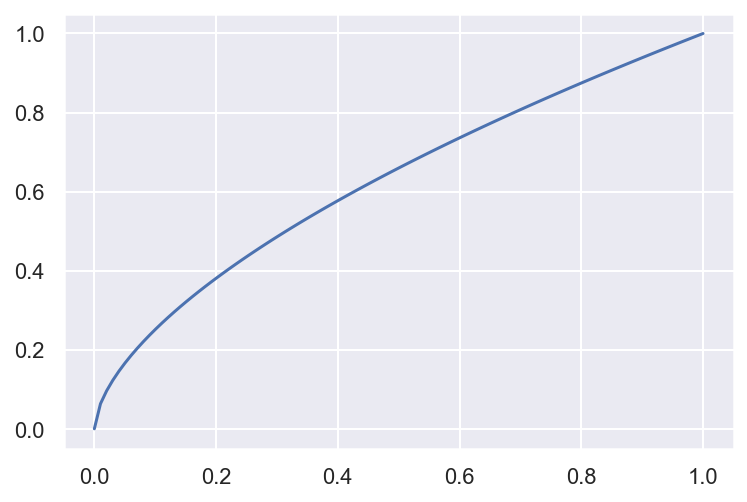

In [10]:
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, u(x_plot, true_alpha))

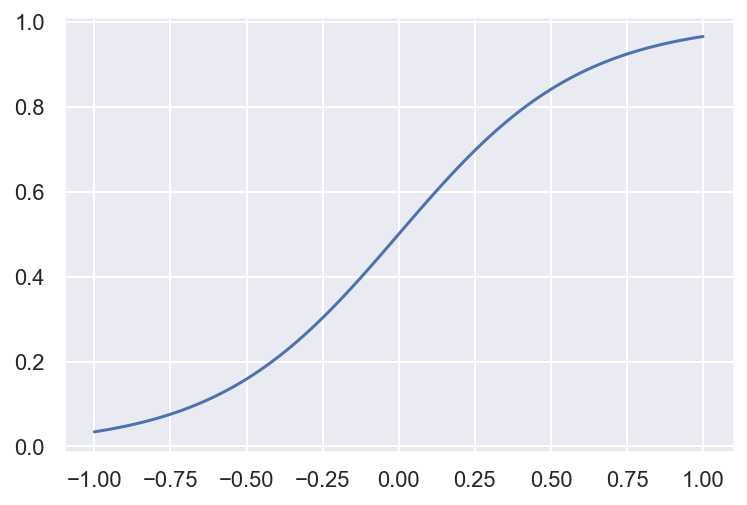

In [11]:
x_plot = np.linspace(-1, 1, 100)
plt.plot(x_plot, f_choice(x_plot, true_tau))

In [12]:
p0 = task.p0.values
p1 = task.p1.values
x0 = task.x0.values
x1 = task.x1.values
y = task.choice.values
diff_eu = task.diff_eu.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))
x_order = np.argsort(x)
x_sorted = x[x_order]
undo_sorted = np.argsort(x_order)

u_sorted = u(x_sorted, true_alpha)
p_sorted = p[x_order]
eu_sorted = p_sorted*u_sorted
p_choice1 = f_choice(diff_eu, true_tau)

print(len(x_sorted))
print(n)

200
100


# Model Discrepancy

## Assuming alpha is NOT known

In [206]:
def build_model():
    with pm.Model() as model:

        ρ = pm.InverseGamma('ρ', 2, 2)
        η = pm.HalfCauchy('η', 5)

        α = pm.Normal('α', 0, 100)  # pm.Bound(pm.Flat, upper=1)('α')

        X = x_sorted.reshape(-1, 1)
        uX = X **pm.math.exp(α)

        M = pm.gp.mean.Constant(uX.flatten())
        K = tt.dot(uX, uX.T) * η**2 * pm.gp.cov.ExpQuad(1, ρ)

        gp = pm.gp.Latent(mean_func=M, cov_func=K)

        # Place a GP prior over the function f.
        f = gp.prior("f", X=X)

        est_eu =  p_sorted * f    
        est_eu_unsorted = est_eu[undo_sorted]

        diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])

        tau_hat = true_tau
        est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
        choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)
    return model, gp

### Map

In [207]:
model, gp = build_model()

In [208]:
with model:
    mp = pm.find_MAP()

In [210]:
pd.DataFrame({var: mp[var] for var in ('α', 'ρ', 'η')}, index=(0,))

,α,ρ,η
0,-0.032509,0.623122,1.330452


In [214]:
- np.exp(mp['α']) + 1

0.031985923171163

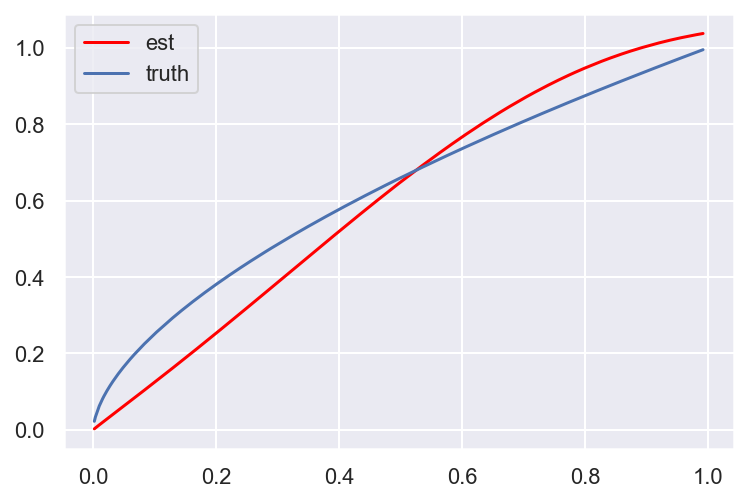

In [215]:
fig, ax = plt.subplots()
ax.plot(x_sorted, mp['f'], color='red', label='est')
ax.plot(x_sorted, u(x_sorted, true_alpha), color='C0', label='truth')
ax.legend()

### VI

In [216]:
model, gp = build_model()

In [217]:
with model:
    mean_field = pm.fit(method="advi", n=20000)

Finished [100%]: Average Loss = 74.205


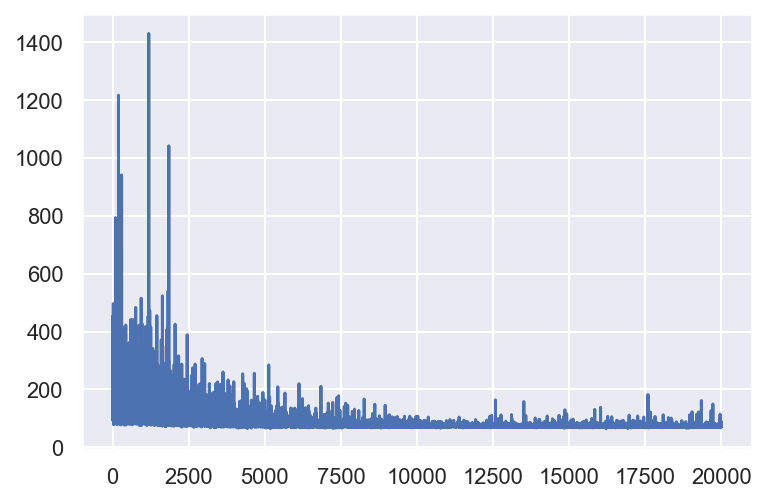

In [218]:
plt.plot(mean_field.hist);

In [219]:
trace_vi = mean_field.sample(1000)

In [220]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace_vi, var_names=["f"])

(0.0, 1.1)

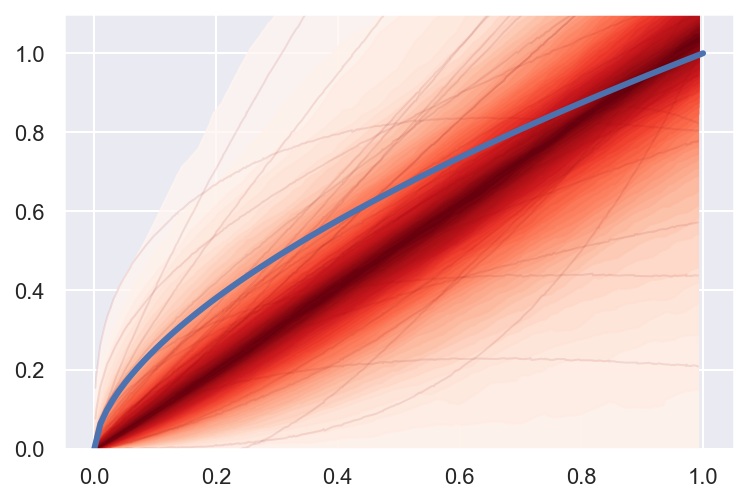

In [221]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted.reshape(-1, 1))
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)
ax.set_ylim(0, 1.1)

### MCMC

In [222]:
model, gp = build_model()

In [223]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, α, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 355 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8373391130267256, but should be close to 0.9. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<AxesSubplot:>

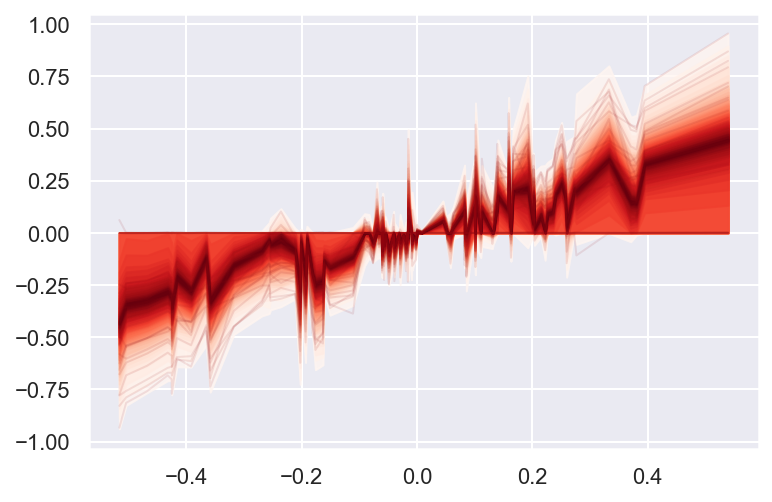

In [224]:
fig, ax = plt.subplots()
# ax.plot(trace['diff_eu_hat', 0, 0].T, 'r', alpha=.03)
pm.gp.util.plot_gp_dist(ax, trace.posterior["diff_eu_hat"][0, :, :], diff_eu)

<AxesSubplot:>

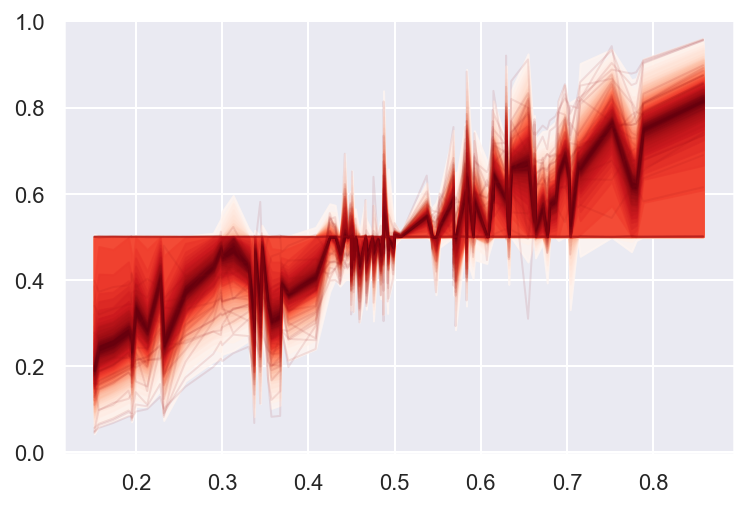

In [225]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["est_p_choice1"][0, :, :], p_choice1)

(0.0, 1.1)

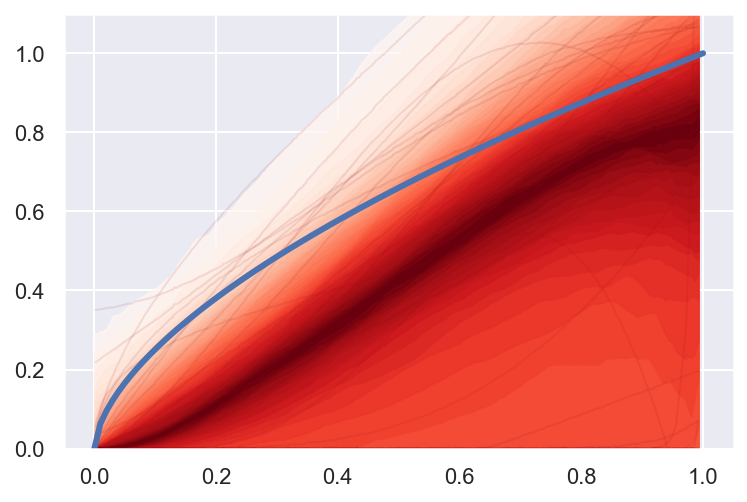

In [226]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["f"][0, :, :], x_sorted)

x_plot = np.linspace(0, 1, 100)
# ax.scatter(x_sorted, u(x_sorted, alpha=true_alpha), color='b', alpha=0.2)
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)
ax.set_ylim(0, 1.1)

array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>,
       <AxesSubplot:title={'center':'α'}>], dtype=object)

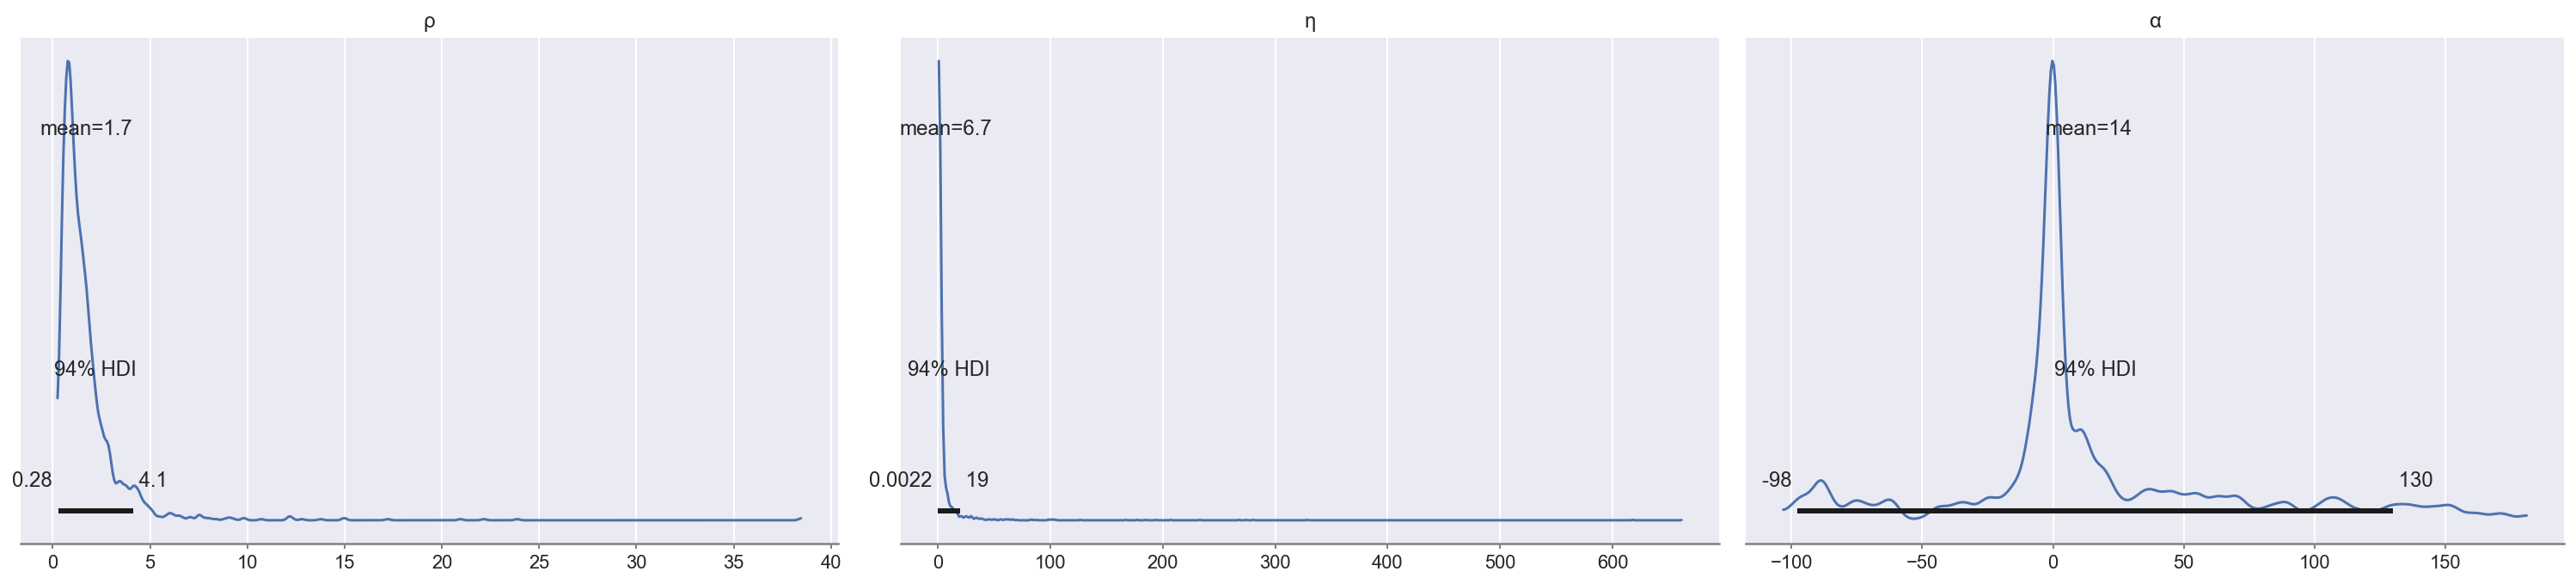

In [227]:
az.plot_posterior(trace, var_names=['ρ', 'η', 'α'])

## Assuming alpha is known

In [4]:
def build_model():
    with pm.Model() as model:

        ρ = pm.InverseGamma('ρ', 2, 2)
        η = pm.HalfCauchy('η', 5)

        X = x_sorted.reshape(-1, 1)
        uX = u(X, alpha=true_alpha)

        M = pm.gp.mean.Constant(uX.flatten())
        K = tt.dot(uX, uX.T) * η**2 * pm.gp.cov.ExpQuad(1, ρ)

        gp = pm.gp.Latent(mean_func=M, cov_func=K)

        # Place a GP prior over the function f.
        f = gp.prior("f", X=X)

        est_eu =  p_sorted * f    
        est_eu_unsorted = est_eu[undo_sorted]

        diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])

        tau_hat = true_tau
        est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
        choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)
    return model, gp

### Map

In [258]:
model, gp = build_model()

In [259]:
with model:
    mp = pm.find_MAP()

In [260]:
pd.DataFrame({var: mp[var] for var in ('ρ', 'η')}, index=(0,))

,ρ,η
0,0.587553,1.82953


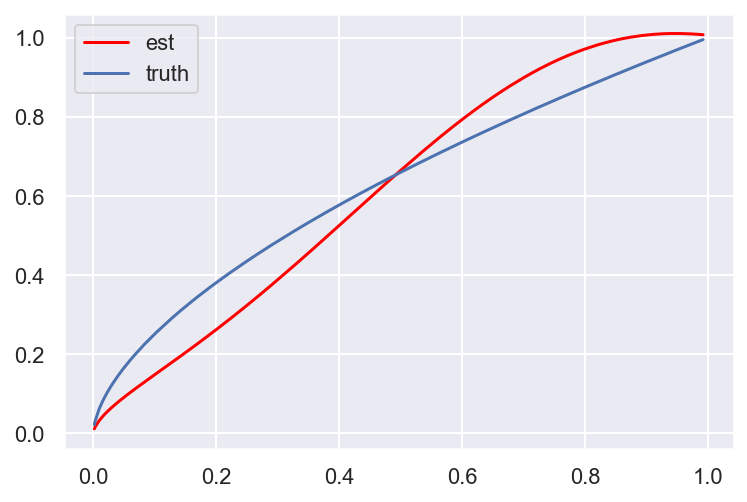

In [261]:
# Neither pm.sample_posterior_predictive or gp.predict is working
fig, ax = plt.subplots()
ax.plot(x_sorted, mp['f'], color='red', label='est')
ax.plot(x_sorted, u(x_sorted, true_alpha), color='C0', label='truth')
ax.legend()

In [268]:
# gp.predict does not work with latent GPs
with model:
    pred_samples = pm.sample_posterior_predictive([mp, ], var_names=["f"], samples=1)

<AxesSubplot:>

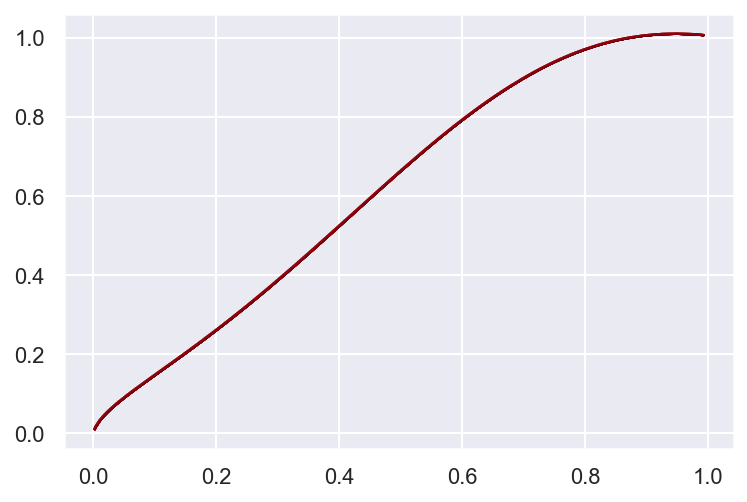

In [269]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted)

### VI

In [31]:
model, gp = build_model()

In [32]:
with model:
    mean_field = pm.fit(method="advi", n=10000)

Finished [100%]: Average Loss = 68.887


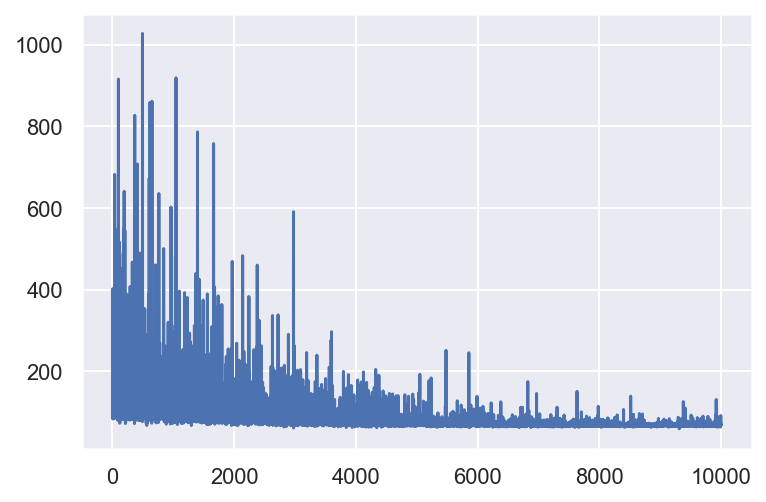

In [33]:
plt.plot(mean_field.hist);

In [34]:
trace_vi = mean_field.sample(1000)

In [17]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace_vi, var_names=["f"])

(0.0, 1.1)

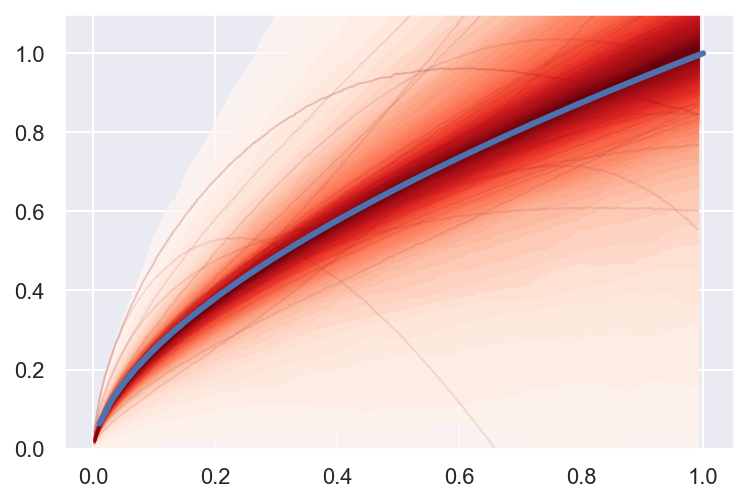

In [18]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted.reshape(-1, 1))
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)
ax.set_ylim(0, 1.1)

### With new points

In [35]:
Xnew = np.linspace(-1, 2, 200).reshape(-1, 1)
with model:
    gp.conditional('f_pred', Xnew=Xnew)
with model:
    pred_samples_new = pm.sample_posterior_predictive(trace_vi, var_names=["f_pred"])

LinAlgError: Matrix is not positive definite

In [ ]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples_new["f_pred"], Xnew)
ax.plot(Xnew.flatten(), u(Xnew.flatten(), alpha=true_alpha), lw=3)
# ax.set_ylim(0, 1.1)

### MCMC

In [240]:
model, gp = build_model()

In [241]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, 
                  target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 177 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<AxesSubplot:>

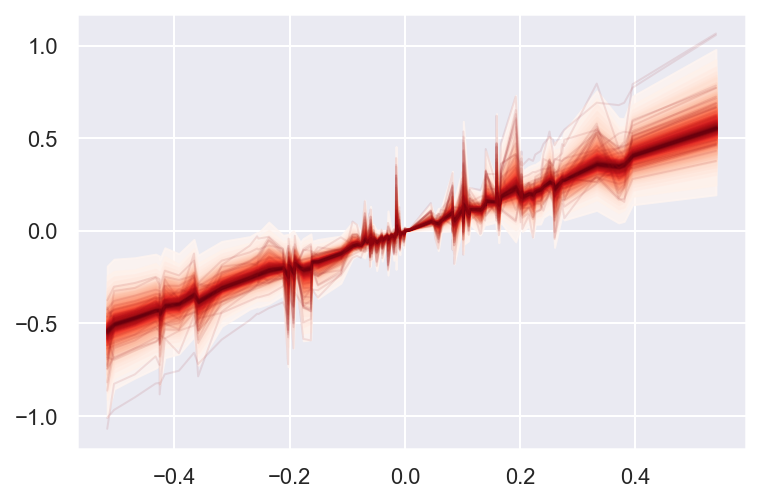

In [246]:
fig, ax = plt.subplots()
# ax.plot(trace['diff_eu_hat', 0, 0].T, 'r', alpha=.03)
pm.gp.util.plot_gp_dist(ax, trace.posterior["diff_eu_hat"][0, :, :], diff_eu)

<AxesSubplot:>

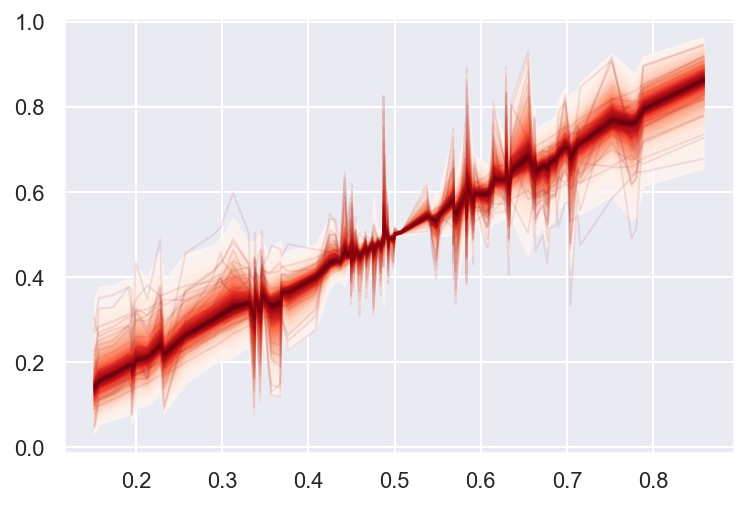

In [247]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["est_p_choice1"][0, :, :], p_choice1)

(0.0, 1.1)

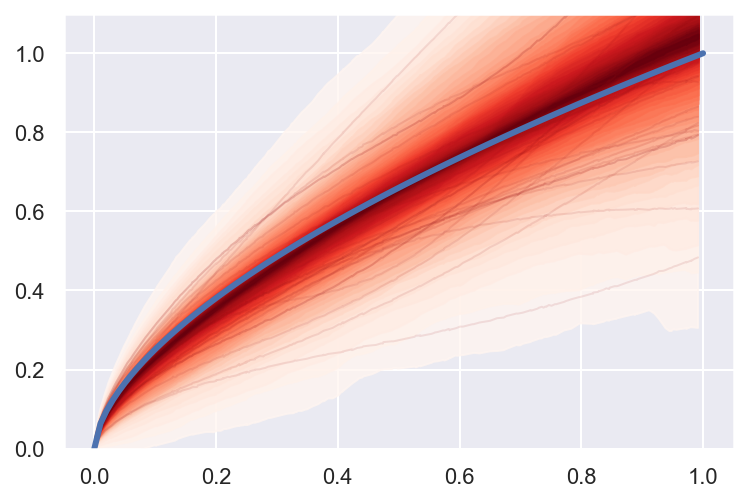

In [249]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["f"][0, :, :], x_sorted)

x_plot = np.linspace(0, 1, 100)
# ax.scatter(x_sorted, u(x_sorted, alpha=true_alpha), color='b', alpha=0.2)
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)
ax.set_ylim(0, 1.1)

array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>], dtype=object)

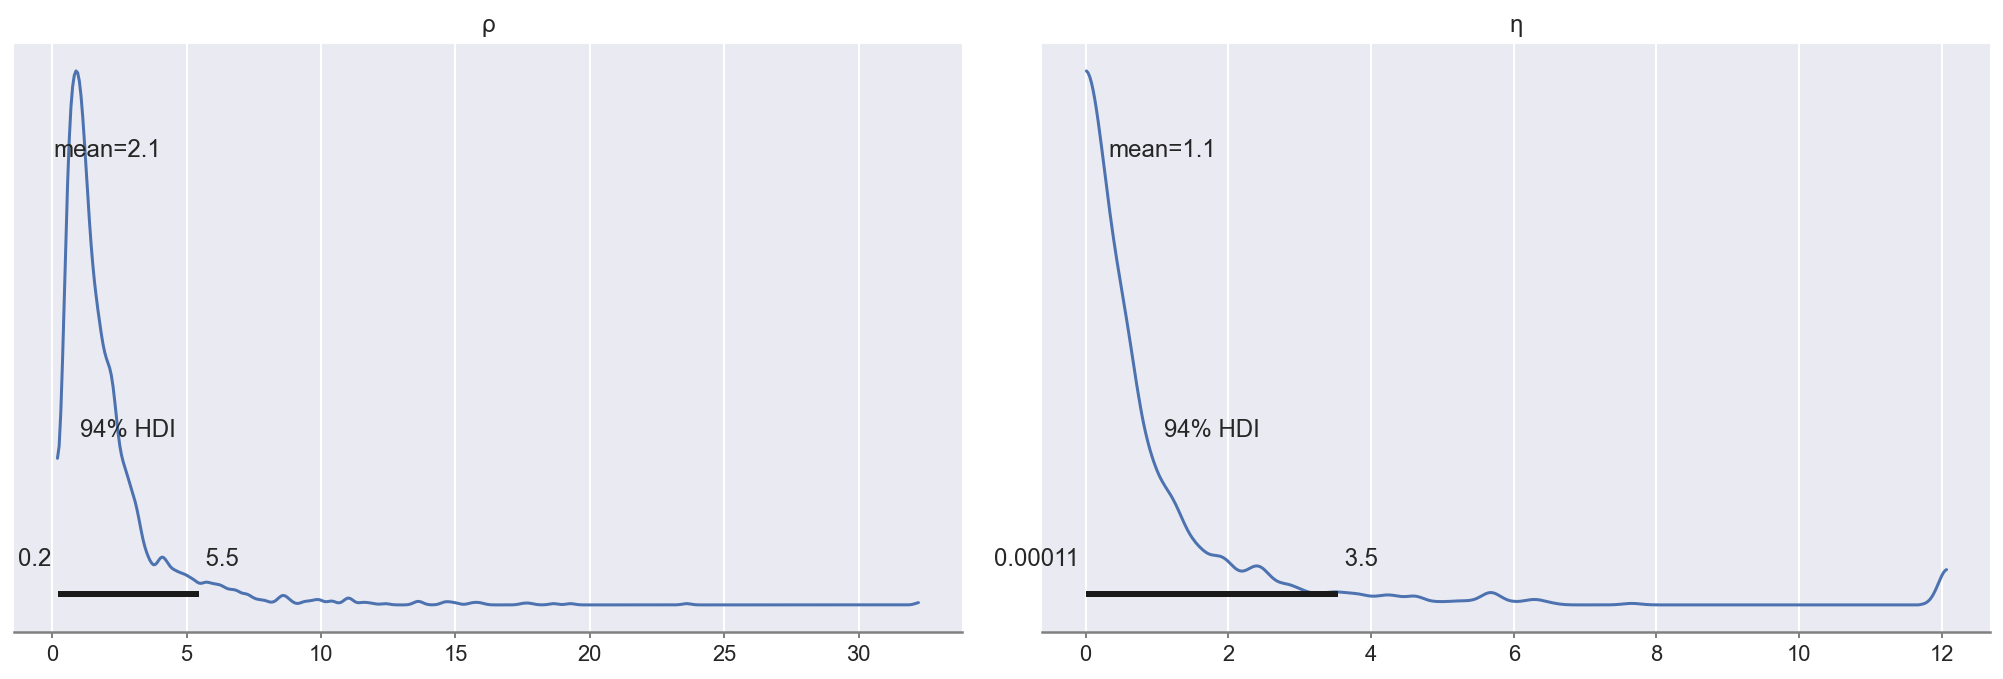

In [245]:
az.plot_posterior(trace, var_names=['ρ', 'η',])